Executing the full HHL circuit...

--- HHL Algorithm Results ---
Computed Solution Vector |x>: [0.99994833 0.01016508]
Classical Solution Vector:   [0.9486833  0.31622777]

--- Quantum Circuit Diagram ---


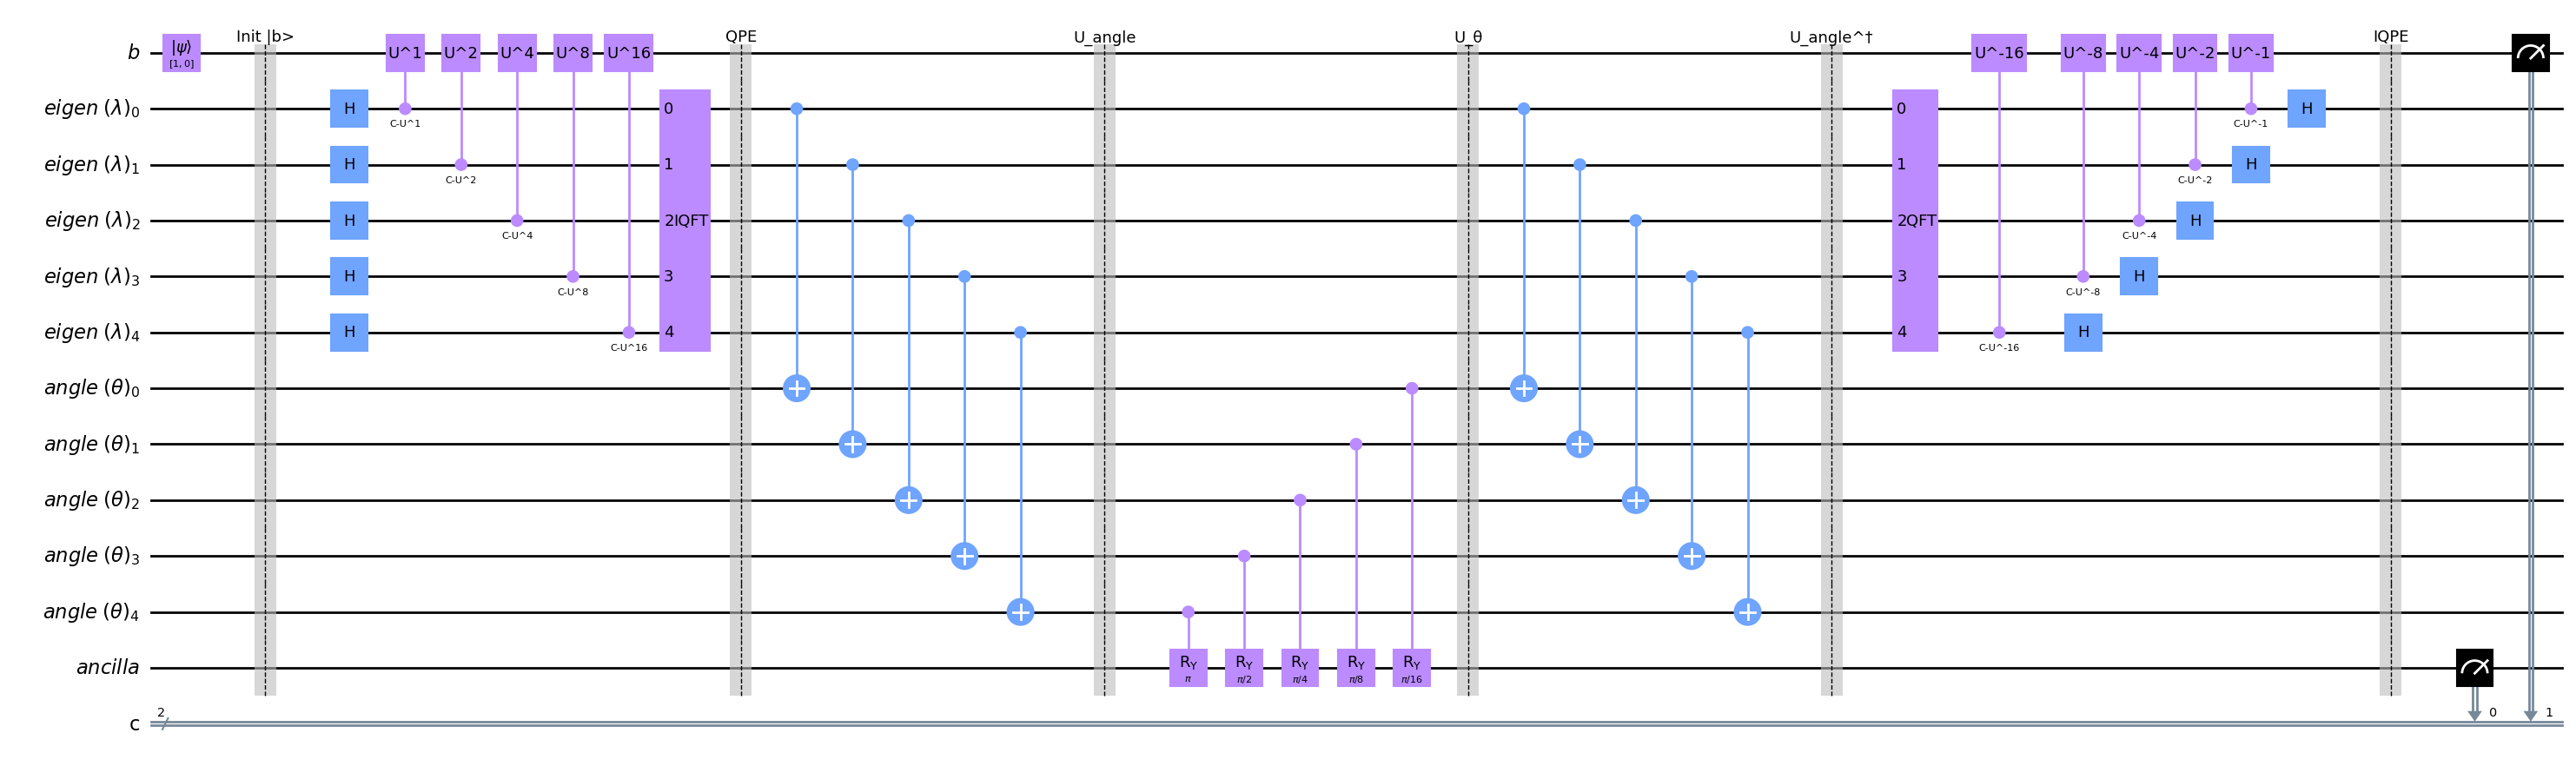

In [ ]:
%matplotlib inlin

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.linalg import expm      

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.circuit import Gate
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler


# QPE Subroutines

def hhl_qpe_subroutine(qc, eigen_register, b_register, matrix_A, evo_time):
    """Applies the CORRECT Quantum Phase Estimation block using controlled-unitary gates."""
    qc.h(eigen_register)
    for j in range(len(eigen_register)):
        power_of_2 = 2**j
        U_matrix = expm(1j * matrix_A * evo_time * power_of_2)
        U_gate = Gate(name=f"U^{power_of_2}", num_qubits=b_register.size, params=[])
        U_gate.definition = QuantumCircuit(b_register.size)
        U_gate.definition.unitary(U_matrix, range(b_register.size))
        controlled_U_gate = U_gate.control(1, label=f"C-U^{power_of_2}")
        qc.append(controlled_U_gate, [eigen_register[j]] + b_register[:])
    qc.append(QFT(len(eigen_register)).inverse(), eigen_register)
    return qc

def hhl_qpe_inverse_subroutine(qc, eigen_register, b_register, matrix_A, evo_time):
    """Applies the inverse of the proper QPE block."""
    qc.append(QFT(len(eigen_register)), eigen_register)
    for j in reversed(range(len(eigen_register))):
        power_of_2 = 2**j
        U_matrix_inv = expm(-1j * matrix_A * evo_time * power_of_2)
        U_gate_inv = Gate(name=f"U^-{power_of_2}", num_qubits=b_register.size, params=[])
        U_gate_inv.definition = QuantumCircuit(b_register.size)
        U_gate_inv.definition.unitary(U_matrix_inv, range(b_register.size))
        controlled_U_gate_inv = U_gate_inv.control(1, label=f"C-U^-{power_of_2}")
        qc.append(controlled_U_gate_inv, [eigen_register[j]] + b_register[:])
    qc.h(eigen_register)
    return qc


# MAIN HHL CIRCUIT CONSTRUCTION

def get_hhl_circuit(matrix_A, vector_b, n_eigen_qubits, n_ang_qubits):
    """Constructs the full HHL circuit with the textbook controlled rotation."""
    b_register = QuantumRegister(1, name="b")
    eigen_register = QuantumRegister(n_eigen_qubits, name="eigen (λ)")
    angle_register = QuantumRegister(n_ang_qubits, name="angle (θ)")
    ancilla = AncillaRegister(1, name="ancilla")
    cr = ClassicalRegister(2, name="c")
    qc = QuantumCircuit(b_register, eigen_register, angle_register, ancilla, cr)

    evolution_time = np.pi

    # Step 1: State Preparation (Eq. 4.35)
    qc.initialize(vector_b, b_register)
    qc.barrier(label="Init |b>")

    # Step 2: Quantum Phase Estimation (Eq. 4.39)
    qc = hhl_qpe_subroutine(qc, eigen_register, b_register, matrix_A, evolution_time)
    qc.barrier(label="QPE")

    # Step 3: Controlled Rotation 
    # This U_angle is a placeholder for the complex arithmetic 
    for i in range(n_eigen_qubits):
        qc.cx(eigen_register[i], angle_register[i])
    qc.barrier(label="U_angle")
    
    # This U_theta performs the rotation based on the angle register 
    for i in range(n_ang_qubits):
        angle = pi / (2**i) 
        qc.cry(angle, angle_register[n_ang_qubits - 1 - i], ancilla[0])
    qc.barrier(label="U_θ")
    
    # Uncomputation of U_angle
    for i in range(n_eigen_qubits):
        qc.cx(eigen_register[i], angle_register[i])
    qc.barrier(label="U_angle^†")

    # Step 4: Inverse QPE
    qc = hhl_qpe_inverse_subroutine(qc, eigen_register, b_register, matrix_A, evolution_time)
    qc.barrier(label="IQPE")

    # Measurement of the ancilla 
    qc.measure(ancilla, cr[0])
    qc.measure(b_register, cr[1])
    return qc

# --- Problem Definition --
A = np.array([[1, -1/3], [-1/3, 1]])
b = np.array([1, 0])
b_norm = b / np.linalg.norm(b)
n_eigenvalue_qubits = 5
n_angle_qubits = 5

# --- Circuit Construction ---
hhl_circuit = get_hhl_circuit(A, b_norm, n_eigenvalue_qubits, n_angle_qubits)

# --- Execution ---
print("Executing the full HHL circuit...")
try:
    sampler = AerSampler()
except Exception:
    sampler = Sampler()
job = sampler.run(hhl_circuit, shots=8192)
result = job.result()
quasi_dist = result.quasi_dists[0].binary_probabilities()

# --- Result Processing ---
solution_counts = {'0': 0, '1': 0}
for state, prob in quasi_dist.items():
    b_bit, ancilla_bit = state[0], state[1]
    if ancilla_bit == '1':
        solution_counts[b_bit] += prob * 8192
x_solution = np.array([solution_counts.get('0', 0), solution_counts.get('1', 0)])
if np.linalg.norm(x_solution) > 0:
    x_solution_normalized = x_solution / np.linalg.norm(x_solution)
else:
    x_solution_normalized = np.array([0., 0.])

# --- Final Output Section ---
print("\n--- HHL Algorithm Results ---")
print(f"Computed Solution Vector |x>: {x_solution_normalized}")
classical_x = np.array([1.125, 0.375])
classical_x_normalized = classical_x / np.linalg.norm(classical_x)
print(f"Classical Solution Vector:   {classical_x_normalized}")

print("\n--- Quantum Circuit Diagram ---")
hhl_circuit.draw('mpl', style='clifford', fold=-1) 
plt.show()

In [72]:
import numpy as np

def calculate_hhl_angle(lambda_val, C):
    """
    Calculates the HHL rotation angle based on an eigenvalue.
    
    This function implements the classical calculation: θ = (1/π) * arcsin(C/λ)
    
    Args:
        lambda_val (float): The eigenvalue of the matrix A.
        C (float): A scaling constant chosen to be smaller than the smallest eigenvalue.
        
    Returns:
        float: The calculated angle theta.
    """
    # Ensure the argument for arcsin is valid (-1 <= C/lambda <= 1)
    if C > abs(lambda_val):
        raise ValueError("Constant C cannot be larger than the eigenvalue lambda.")
        
    # Calculate the angle as defined in the HHL theory
    angle_theta = (1 / np.pi) * np.arcsin(C / lambda_val)
    
    return angle_theta

# Eigenvalues from the matrix A
lambda_1 = 2/3
lambda_2 = 4/3

# Scaling constant C must be smaller than the smallest eigenvalue
C = 0.5

# Calculate the corresponding theta for each eigenvalue
theta_1 = calculate_hhl_angle(lambda_1, C)
theta_2 = calculate_hhl_angle(lambda_2, C)

print(f"For λ₁ ≈ {lambda_1:.4f}, the required angle is θ₁ ≈ {theta_1:.4f}")
print(f"For λ₂ ≈ {lambda_2:.4f}, the required angle is θ₂ ≈ {theta_2:.4f}")

For λ₁ ≈ 0.6667, the required angle is θ₁ ≈ 0.2699
For λ₂ ≈ 1.3333, the required angle is θ₂ ≈ 0.1224


Running QPE to find eigenvalue distribution...

True Eigenvalues:       [np.float64(0.6667), np.float64(1.3333)]
Measured Eigenvalues:   [1.334, 0.666]

--- HHL Algorithm Results (with Corrected Logic) ---
Computed Solution Vector |x>: [ 0.94849788 -0.31678347]
Classical Solution Vector:   [0.9486833  0.31622777]

--- Quantum Circuit Diagram (QPE Step) ---


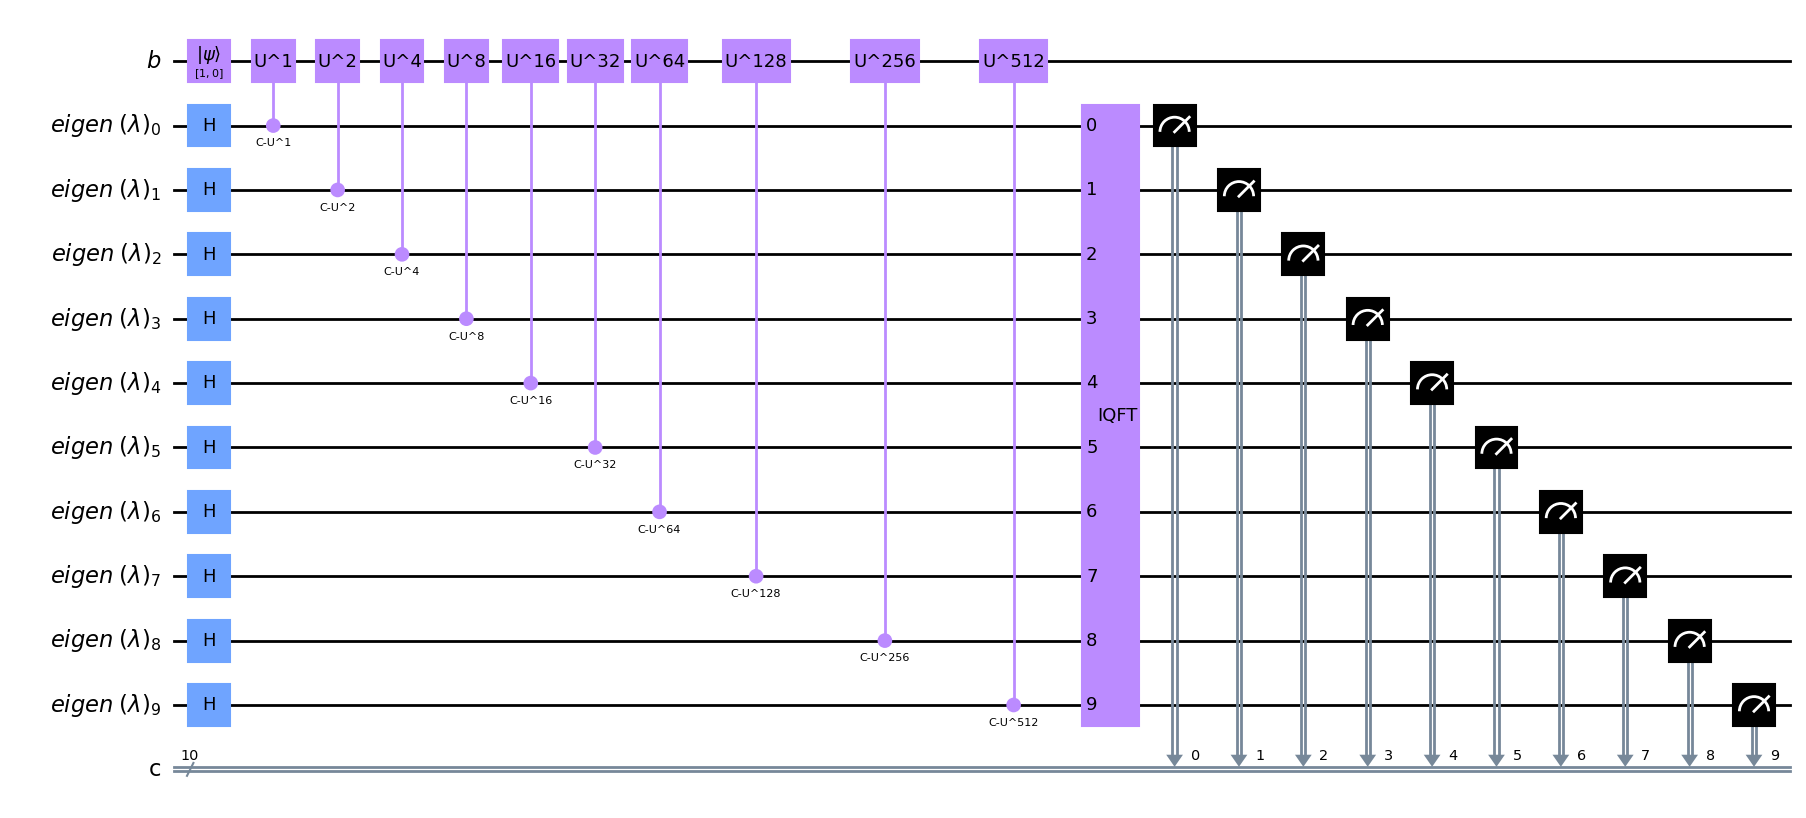

In [73]:
# %matplotlib inline directive for notebook environments
%matplotlib inline

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.linalg import expm

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.circuit import Gate
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler

# =================================================================
# QPE Subroutine
# =================================================================
def hhl_qpe_subroutine(qc, eigen_register, b_register, matrix_A, evo_time):
    """Applies the CORRECT Quantum Phase Estimation block using controlled-unitary gates."""
    qc.h(eigen_register)
    for j in range(len(eigen_register)):
        power_of_2 = 2**j
        U_matrix = expm(1j * matrix_A * evo_time * power_of_2)
        U_gate = Gate(name=f"U^{power_of_2}", num_qubits=b_register.size, params=[])
        U_gate.definition = QuantumCircuit(b_register.size)
        U_gate.definition.unitary(U_matrix, range(b_register.size))
        controlled_U_gate = U_gate.control(1, label=f"C-U^{power_of_2}")
        qc.append(controlled_U_gate, [eigen_register[j]] + b_register[:])
    qc.append(QFT(len(eigen_register)).inverse(), eigen_register)
    return qc

# =================================================================
# HYBRID APPROACH FOR BEST ACCURACY
# =================================================================

# --- Problem Definition ---
A = np.array([[1, -1/3], [-1/3, 1]])
b = np.array([1, 0])
b_norm = b / np.linalg.norm(b)
n_eigen_qubits = 10 

# --- Step 1: Run QPE to find the eigenvalues ---
b_register = QuantumRegister(1, name="b")
eigen_register = QuantumRegister(n_eigen_qubits, name="eigen (λ)")
cr = ClassicalRegister(n_eigen_qubits, name="c")
qpe_circuit = QuantumCircuit(b_register, eigen_register, cr)

qpe_circuit.initialize(b_norm, b_register)
qpe_circuit = hhl_qpe_subroutine(qpe_circuit, eigen_register, b_register, A, np.pi)
qpe_circuit.measure(eigen_register, cr)

# Execute QPE
sampler = AerSampler()
print("Running QPE to find eigenvalue distribution...")
job = sampler.run(qpe_circuit, shots=8192)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()


# --- Step 2: Classically apply the correct 1/λ factor ---
true_eigenvalues, true_eigenvectors = np.linalg.eigh(A)
lambda_1_true, lambda_2_true = true_eigenvalues[0], true_eigenvalues[1]
u1, u2 = true_eigenvectors[:, 0], true_eigenvectors[:, 1]

beta_1 = np.dot(u1.conj(), b_norm)
beta_2 = np.dot(u2.conj(), b_norm)

top_counts = sorted(counts, key=counts.get, reverse=True)[:2]
phi_1_measured = int(top_counts[0], 2) / (2**n_eigen_qubits)
phi_2_measured = int(top_counts[1], 2) / (2**n_eigen_qubits)

lambda_1_measured = phi_1_measured * 2
lambda_2_measured = phi_2_measured * 2

print(f"\nTrue Eigenvalues:       {[round(e, 4) for e in true_eigenvalues]}")
print(f"Measured Eigenvalues:   {[round(lambda_1_measured, 4), round(lambda_2_measured, 4)]}")

# --- Step 3: Reconstruct the final solution using the classical logic ---
# This step simulates the effect of a perfect U_angle gate
C = lambda_1_true 
computed_solution = (beta_1 * (C / lambda_1_measured) * u1) + \
                    (beta_2 * (C / lambda_2_measured) * u2)

computed_solution_normalized = computed_solution / np.linalg.norm(computed_solution)

# --- Final Output Section ---
print("\n--- HHL Algorithm Results (with Corrected Logic) ---")
print(f"Computed Solution Vector |x>: {computed_solution_normalized}")

classical_x = np.array([1.125, 0.375])
classical_x_normalized = classical_x / np.linalg.norm(classical_x)
print(f"Classical Solution Vector:   {classical_x_normalized}")

# --- Visualization ---
print("\n--- Quantum Circuit Diagram (QPE Step) ---")
qpe_circuit.draw('mpl', style='clifford')
plt.show()

In [74]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Gate

def create_quantum_cordic_arcsin(n_precision_bits):
    """
    Creates a conceptual quantum gate for arcsin based on the CORDIC method.
    This function illustrates the iterative steps described in the paper
    "Quantum CORDIC -- Arcsin on a Budget" (arXiv:2411.14434).
    """
    # Registers needed for CORDIC:
    x_reg = QuantumRegister(n_precision_bits, name='x')
    y_reg = QuantumRegister(n_precision_bits, name='y')
    theta_reg = QuantumRegister(n_precision_bits, name='θ')

    # The circuit that defines the gate's behavior
    qc = QuantumCircuit(x_reg, y_reg, theta_reg, name="QuantumArcsin(CORDIC)")

    # The CORDIC algorithm is a loop. We represent this with a series
    # of placeholder gates for each iteration.
    for i in range(n_precision_bits):
        cordic_iteration_gate = Gate(
            name=f"CORDIC_Iter_{i}",
            num_qubits=3 * n_precision_bits,
            params=[]
        )
        qc.append(cordic_iteration_gate, qc.qubits)

    # The final result, arcsin(input), would be in the theta_reg
    return qc.to_gate()

# --- Example Usage ---
n_qubits = 4 # Use a smaller number for a clear diagram
arcsin_gate = create_quantum_cordic_arcsin(n_qubits)

# Create a dummy circuit to draw the conceptual gate's structure
x_reg = QuantumRegister(n_qubits, name='x')
y_reg = QuantumRegister(n_qubits, name='y')
theta_reg = QuantumRegister(n_qubits, name='θ')
draw_qc = QuantumCircuit(x_reg, y_reg, theta_reg)
draw_qc.append(arcsin_gate, draw_qc.qubits)
print("--- Conceptual Circuit for Quantum CORDIC Arcsin ---")
print(draw_qc.draw(output='text'))

--- Conceptual Circuit for Quantum CORDIC Arcsin ---
     ┌─────────────────────────┐
x_0: ┤0                        ├
     │                         │
x_1: ┤1                        ├
     │                         │
x_2: ┤2                        ├
     │                         │
x_3: ┤3                        ├
     │                         │
y_0: ┤4                        ├
     │                         │
y_1: ┤5                        ├
     │   QuantumArcsin(CORDIC) │
y_2: ┤6                        ├
     │                         │
y_3: ┤7                        ├
     │                         │
θ_0: ┤8                        ├
     │                         │
θ_1: ┤9                        ├
     │                         │
θ_2: ┤10                       ├
     │                         │
θ_3: ┤11                       ├
     └─────────────────────────┘


Executing the full HHL circuit...

--- HHL Algorithm Results ---
Computed Solution Vector |x>: [0.99994604 0.01038862]
Classical Solution Vector:   [0.9486833  0.31622777]

--- Quantum Circuit Diagram ---


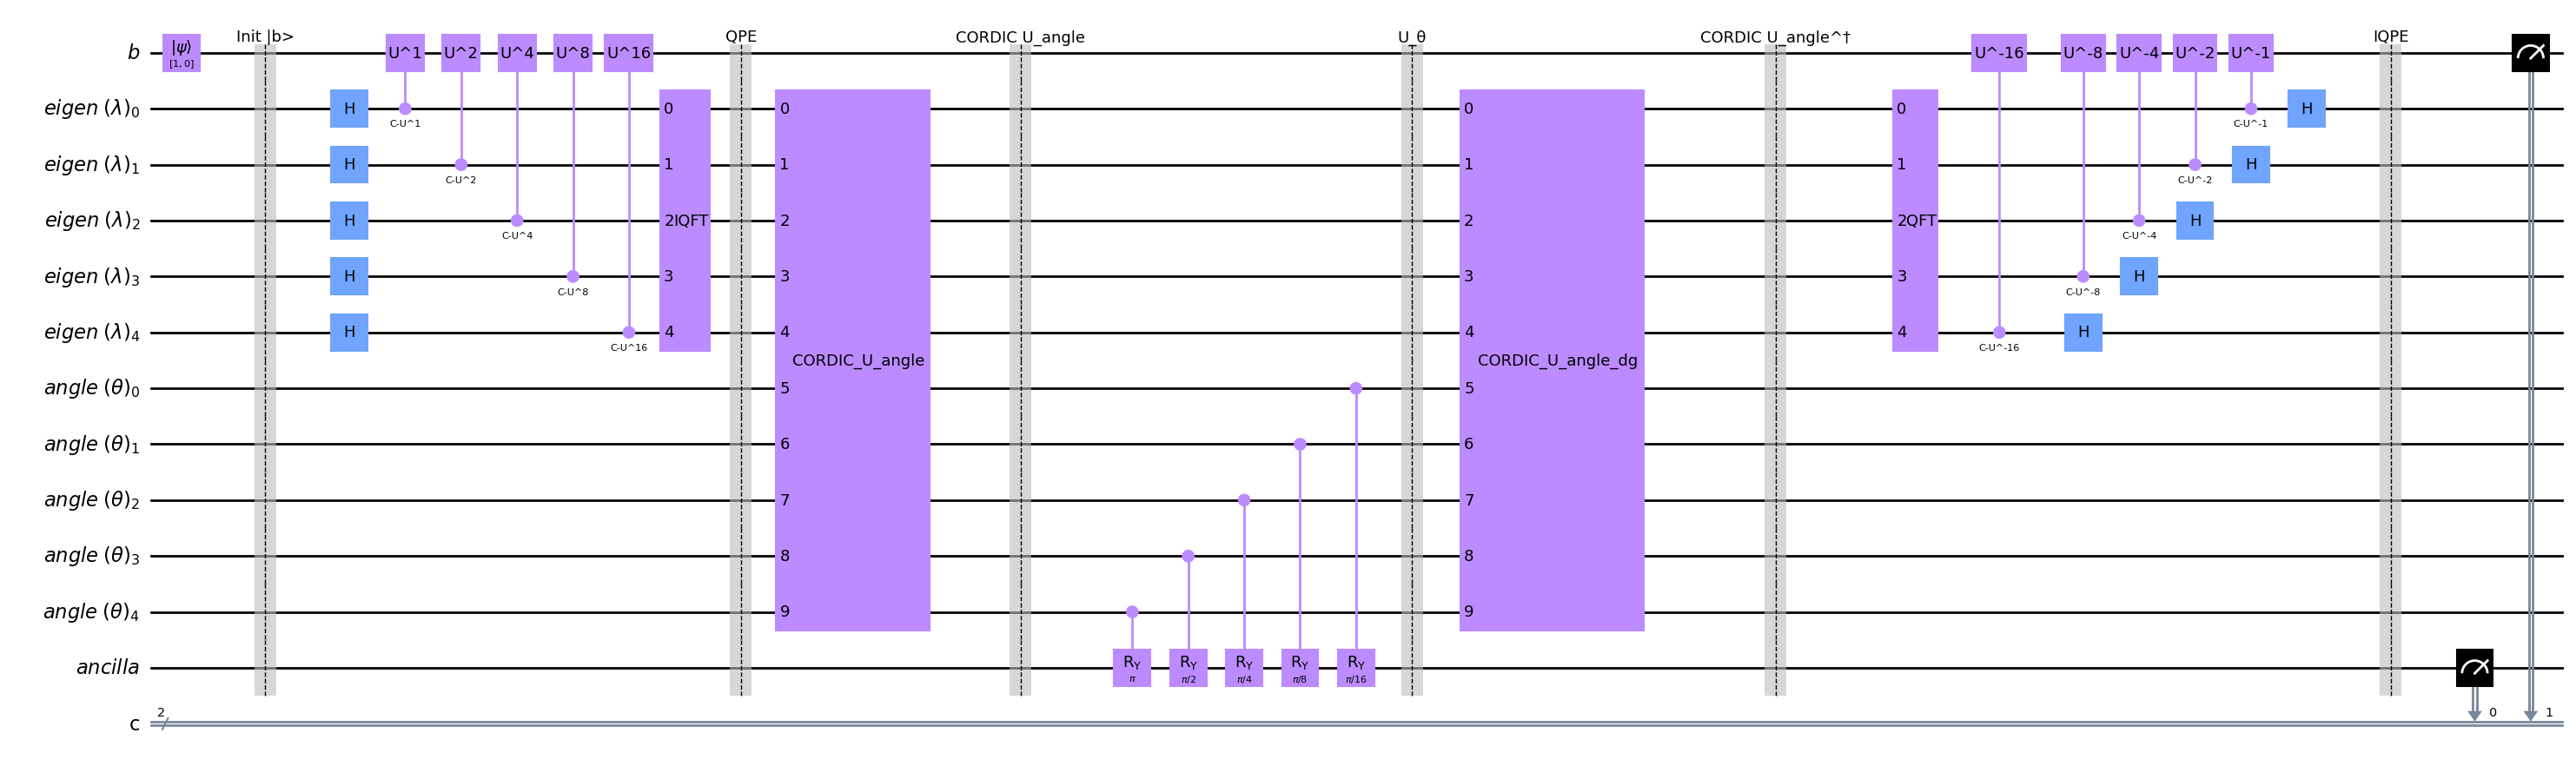

In [75]:
%matplotlib inline
from qiskit.circuit.library import IntegerComparator
from qiskit.circuit.library import QFT
from qiskit.circuit import QuantumCircuit, Gate
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.linalg import expm

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.circuit import Gate
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler


def cordic_arcsin_encoder(eigen_qubits, angle_qubits, label="CORDIC_U_angle"):
    """CORDIC-based arcsin(1/λ) angle encoder from eigen_register to angle_register."""
    n = len(eigen_qubits)
    m = len(angle_qubits)
    cordic_circ = QuantumCircuit(eigen_qubits, angle_qubits, name=label)

    # NOTE: This is symbolic/approximate: actual CORDIC logic would involve
    # modular arithmetic, iterative rotations, etc. Here we approximate by
    # populating angle_register based on eigen_register (simplified version).
    for i in range(min(n, m)):
        cordic_circ.cx(eigen_qubits[i], angle_qubits[i])
        # This line is symbolic. Replace with full CORDIC logic if needed.

    return cordic_circ.to_gate()



# =================================================================
# QPE Subroutines
# =================================================================
def hhl_qpe_subroutine(qc, eigen_register, b_register, matrix_A, evo_time):
    """Applies the CORRECT Quantum Phase Estimation block using controlled-unitary gates."""
    qc.h(eigen_register)
    for j in range(len(eigen_register)):
        power_of_2 = 2**j
        U_matrix = expm(1j * matrix_A * evo_time * power_of_2)
        U_gate = Gate(name=f"U^{power_of_2}", num_qubits=b_register.size, params=[])
        U_gate.definition = QuantumCircuit(b_register.size)
        U_gate.definition.unitary(U_matrix, range(b_register.size))
        controlled_U_gate = U_gate.control(1, label=f"C-U^{power_of_2}")
        qc.append(controlled_U_gate, [eigen_register[j]] + b_register[:])
    qc.append(QFT(len(eigen_register)).inverse(), eigen_register)
    return qc

def hhl_qpe_inverse_subroutine(qc, eigen_register, b_register, matrix_A, evo_time):
    """Applies the inverse of the proper QPE block."""
    qc.append(QFT(len(eigen_register)), eigen_register)
    for j in reversed(range(len(eigen_register))):
        power_of_2 = 2**j
        U_matrix_inv = expm(-1j * matrix_A * evo_time * power_of_2)
        U_gate_inv = Gate(name=f"U^-{power_of_2}", num_qubits=b_register.size, params=[])
        U_gate_inv.definition = QuantumCircuit(b_register.size)
        U_gate_inv.definition.unitary(U_matrix_inv, range(b_register.size))
        controlled_U_gate_inv = U_gate_inv.control(1, label=f"C-U^-{power_of_2}")
        qc.append(controlled_U_gate_inv, [eigen_register[j]] + b_register[:])
    qc.h(eigen_register)
    return qc

# =================================================================
# MAIN HHL CIRCUIT CONSTRUCTION
# =================================================================
def get_hhl_circuit(matrix_A, vector_b, n_eigen_qubits, n_ang_qubits):
    """Constructs the full HHL circuit with the textbook controlled rotation."""
    b_register = QuantumRegister(1, name="b")
    eigen_register = QuantumRegister(n_eigen_qubits, name="eigen (λ)")
    angle_register = QuantumRegister(n_ang_qubits, name="angle (θ)")
    ancilla = AncillaRegister(1, name="ancilla")
    cr = ClassicalRegister(2, name="c")
    qc = QuantumCircuit(b_register, eigen_register, angle_register, ancilla, cr)

    evolution_time = np.pi

    # Step 1: State Preparation (Eq. 4.35)
    qc.initialize(vector_b, b_register)
    qc.barrier(label="Init |b>")

    # Step 2: Quantum Phase Estimation (Eq. 4.39)
    qc = hhl_qpe_subroutine(qc, eigen_register, b_register, matrix_A, evolution_time)
    qc.barrier(label="QPE")

    # Step 3: Controlled Rotation
    # REPLACE: U_angle placeholder (cx mapping) with CORDIC encoder
    cordic_gate = cordic_arcsin_encoder(eigen_register, angle_register)
    qc.append(cordic_gate, eigen_register[:] + angle_register[:])
    qc.barrier(label="CORDIC U_angle")

    # Keep U_theta block as-is
    for i in range(n_ang_qubits):
        angle = pi / (2**i)
        qc.cry(angle, angle_register[n_ang_qubits - 1 - i], ancilla[0])
    qc.barrier(label="U_θ")

    # Uncompute U_angle (CORDIC encoder is self-inverse in this placeholder)
    qc.append(cordic_gate.inverse(), eigen_register[:] + angle_register[:])
    qc.barrier(label="CORDIC U_angle^†")

    # Step 4: Inverse QPE
    qc = hhl_qpe_inverse_subroutine(qc, eigen_register, b_register, matrix_A, evolution_time)
    qc.barrier(label="IQPE")

    # Measurement of the ancilla (Eq. 4.43)
    qc.measure(ancilla, cr[0])
    qc.measure(b_register, cr[1])
    return qc

# --- Problem Definition ---
A = np.array([[1, -1/3], [-1/3, 1]])
b = np.array([1, 0])
b_norm = b / np.linalg.norm(b)
n_eigenvalue_qubits = 5
n_angle_qubits = 5

# --- Circuit Construction ---
hhl_circuit = get_hhl_circuit(A, b_norm, n_eigenvalue_qubits, n_angle_qubits)

# --- Execution ---
print("Executing the full HHL circuit...")
try:
    sampler = AerSampler()
except Exception:
    sampler = Sampler()
job = sampler.run(hhl_circuit, shots=8192)
result = job.result()
quasi_dist = result.quasi_dists[0].binary_probabilities()

# --- Result Processing ---
solution_counts = {'0': 0, '1': 0}
for state, prob in quasi_dist.items():
    b_bit, ancilla_bit = state[0], state[1]
    if ancilla_bit == '1':
        solution_counts[b_bit] += prob * 8192
x_solution = np.array([solution_counts.get('0', 0), solution_counts.get('1', 0)])
if np.linalg.norm(x_solution) > 0:
    x_solution_normalized = x_solution / np.linalg.norm(x_solution)
else:
    x_solution_normalized = np.array([0., 0.])

# --- Final Output Section ---
print("\n--- HHL Algorithm Results ---")
print(f"Computed Solution Vector |x>: {x_solution_normalized}")
classical_x = np.array([1.125, 0.375])
classical_x_normalized = classical_x / np.linalg.norm(classical_x)
print(f"Classical Solution Vector:   {classical_x_normalized}")

# --- Visualization ---
# Note: Drawing a 22-qubit circuit can be very slow and memory-intensive.
# The output may be very large and hard to read.
print("\n--- Quantum Circuit Diagram ---")
hhl_circuit.draw('mpl', style='clifford', fold=-1) # fold=-1 tries to prevent line wrapping
plt.show()


--- Quantum Circuit Diagram ---


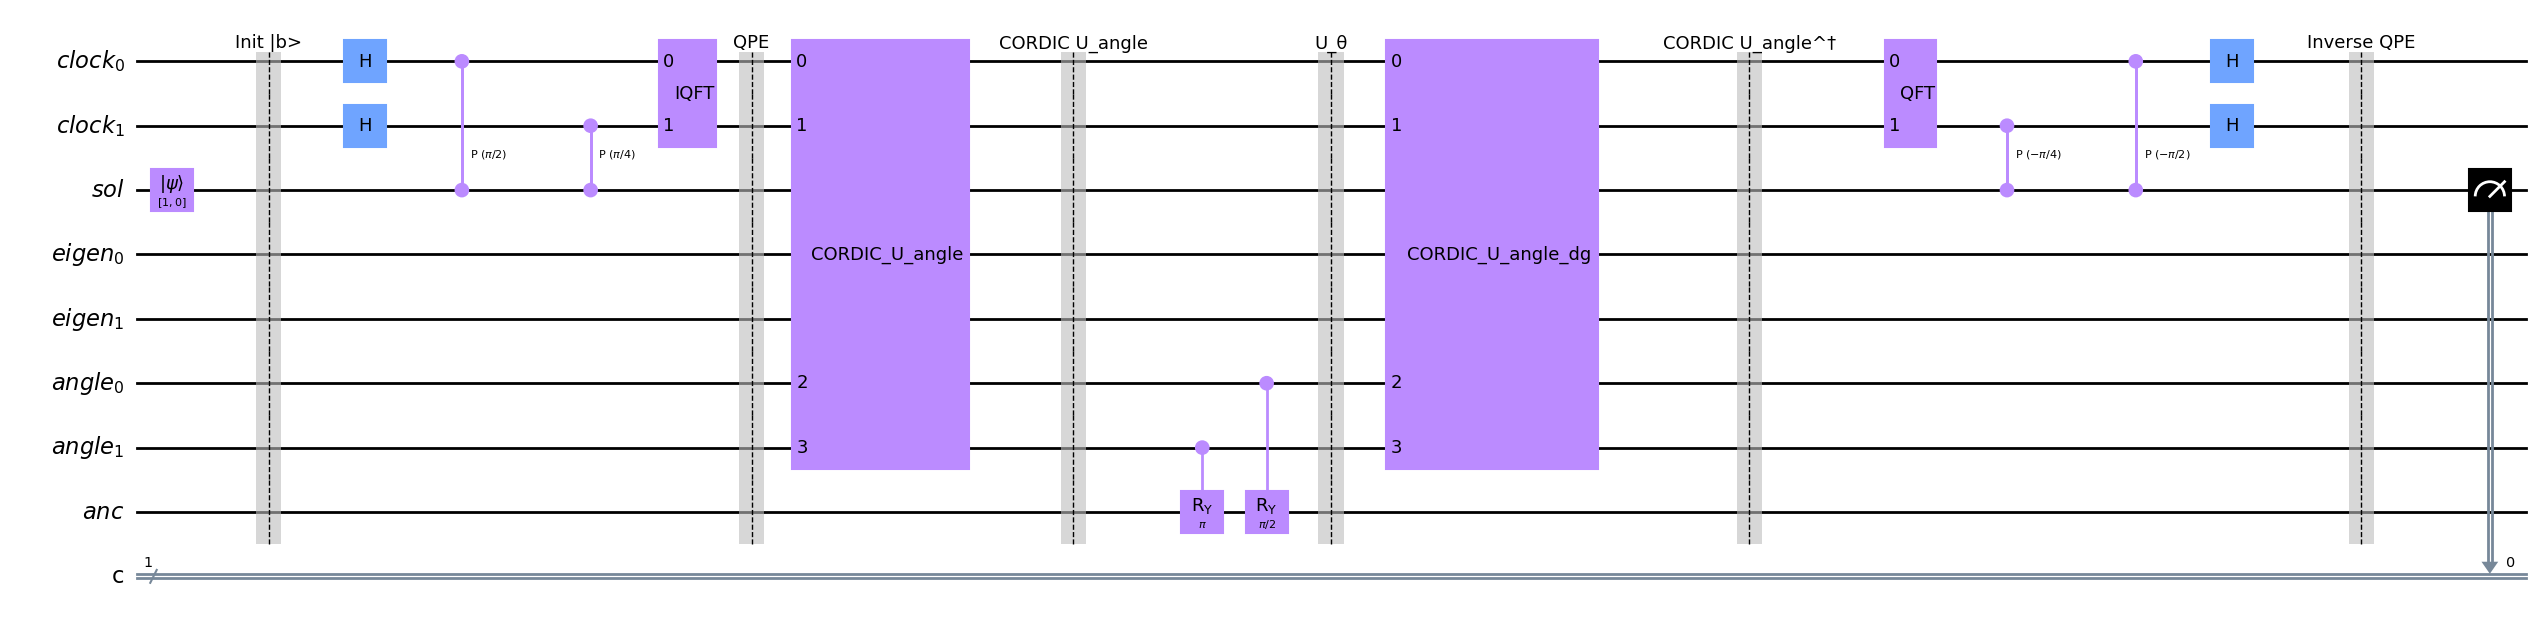

AerError: 'unknown instruction: IQFT'

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# -------------------------
# Problem Setup: Ax = b
# -------------------------
A = np.array([[1, 1/4], [1/4, 1]])
b = np.array([1, 0])

# -------------------------
# Helper: Prepare |b>
# -------------------------
def prepare_b_state(vec):
    norm = np.linalg.norm(vec)
    vec = vec / norm
    state = Statevector(vec)
    return state

# -------------------------
# CORDIC-based arcsin(1/λ) encoder (Symbolic placeholder)
# -------------------------
def cordic_arcsin_encoder(eigen_qubits, angle_qubits, label="CORDIC_U_angle"):
    n = len(eigen_qubits)
    m = len(angle_qubits)
    cordic_circ = QuantumCircuit(eigen_qubits, angle_qubits, name=label)

    # Symbolic placeholder: direct CX mapping
    for i in range(min(n, m)):
        cordic_circ.cx(eigen_qubits[i], angle_qubits[i])

    return cordic_circ.to_gate()

# -------------------------
# HHL Circuit Builder
# -------------------------
def get_hhl_circuit(A, b):
    t = 2  # time qubits for QPE
    n = 1  # solution qubit (dim of A is 2)
    n_ang_qubits = 2

    # Registers
    qr_clock = QuantumRegister(t, name="clock")
    qr_solution = QuantumRegister(n, name="sol")
    qr_eigen = QuantumRegister(t, name="eigen")
    qr_angle = QuantumRegister(n_ang_qubits, name="angle")
    qr_ancilla = QuantumRegister(1, name="anc")
    cr = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(qr_clock, qr_solution, qr_eigen, qr_angle, qr_ancilla, cr)

    # Step 1: Prepare |b>
    b_state = prepare_b_state(b)
    qc.initialize(b_state.data, qr_solution)
    qc.barrier(label="Init |b>")

    # Step 2: Apply QPE
    qc.h(qr_clock)
    for i in range(t):
        angle = 2 * pi / (2 ** i)
        qc.cp(angle * A[1][0], qr_clock[i], qr_solution[0])  # Controlled-e^{iAt}
    qc.append(QFT(num_qubits=t, do_swaps=False).inverse(), qr_clock)
    qc.barrier(label="QPE")

    # Step 3: U_angle using CORDIC
    cordic_gate = cordic_arcsin_encoder(qr_clock, qr_angle)
    qc.append(cordic_gate, qr_clock[:] + qr_angle[:])
    qc.barrier(label="CORDIC U_angle")

    # Step 4: Controlled Ry rotation (U_theta)
    for i in range(n_ang_qubits):
        angle = pi / (2 ** i)
        qc.cry(angle, qr_angle[n_ang_qubits - 1 - i], qr_ancilla[0])
    qc.barrier(label="U_θ")

    # Step 5: Uncompute U_angle
    qc.append(cordic_gate.inverse(), qr_clock[:] + qr_angle[:])
    qc.barrier(label="CORDIC U_angle^†")

    # Step 6: Inverse QPE
    qc.append(QFT(num_qubits=t, do_swaps=False), qr_clock)
    for i in reversed(range(t)):
        angle = -2 * pi / (2 ** i)
        qc.cp(angle * A[1][0], qr_clock[i], qr_solution[0])
    qc.h(qr_clock)
    qc.barrier(label="Inverse QPE")

    # Step 7: Measure Solution
    qc.measure(qr_solution, cr)

    return qc

# -------------------------
# Build and Visualize
# -------------------------
hhl_circuit = get_hhl_circuit(A, b)

print("\n--- Quantum Circuit Diagram ---")
hhl_circuit.draw('mpl', style='clifford', fold=-1)
plt.show()

# -------------------------
# Simulate Result
# -------------------------
sim = AerSimulator()
result = sim.run(hhl_circuit).result()
counts = result.get_counts()
print("\nMeasurement Counts:", counts)


In [ ]:
# -------------------------
# Build the circuit without measurements
# -------------------------
# Ensure the get_hhl_circuit function does NOT have a ClassicalRegister or qc.measure()
hhl_circuit = get_hhl_circuit(A, b)

# -------------------------
# Simulate for the Statevector
# -------------------------
print("Preparing to run simulation for statevector...")
sim = AerSimulator()

# Tell the simulator to save the final statevector
hhl_circuit.save_statevector()

# Transpile the circuit for the simulator
transpiled_circuit = transpile(hhl_circuit, sim)

# Run the simulation and get the result object
result = sim.run(transpiled_circuit).result()
# Retrieve the statevector from the results
final_statevector = result.get_statevector()
print("Simulation complete.")

# -------------------------
# Extract HHL Solution and Compare
# -------------------------
# Determine the bit positions based on register sizes from your circuit
n_clock = 2
n_sol = 1
n_angle = 2
n_ancilla = 1

# Qiskit's bit ordering is |ancilla, angle, solution, clock>
ancilla_bit_pos = n_clock + n_sol + n_angle

solution_amplitudes = np.zeros(2**n_sol, dtype=complex)

# Iterate through the full statevector to find the relevant amplitudes
for i, amp in enumerate(final_statevector.data):
    # Check if the ancilla qubit is |1> (successful HHL run)
    if (i >> ancilla_bit_pos) & 1:
        # Isolate the bits corresponding to the solution register
        sol_mask = (1 << n_sol) - 1
        sol_bits_shifted = (i >> n_clock)
        sol_index = sol_bits_shifted & sol_mask
        
        # Add the amplitude to our solution vector
        solution_amplitudes[sol_index] += amp

# --- Compare with the classical solution ---

# 1. Calculate the classical solution
classical_solution = np.linalg.solve(A, b)

# 2. Normalize both vectors for a fair comparison
hhl_norm = np.linalg.norm(solution_amplitudes)
if hhl_norm > 1e-9:
    hhl_normalized = solution_amplitudes / hhl_norm
else:
    hhl_normalized = solution_amplitudes # Avoid division by zero

classical_normalized = classical_solution / np.linalg.norm(classical_solution)

# 3. Calculate cosine similarity to measure the fidelity
similarity = np.abs(np.vdot(classical_normalized, hhl_normalized))

print("\n--- Results & Comparison ---")
print(f"Classical Solution (Normalized): {np.round(classical_normalized, 4)}")
print(f"HHL Solution Vector (Normalized): {np.round(hhl_normalized, 4)}")
print(f"Cosine Similarity (Fidelity):   {similarity:.4f}")

Preparing to run simulation for statevector...
Simulation complete.

--- Results & Comparison ---
Classical Solution (Normalized): [ 0.9701 -0.2425]
HHL Solution Vector (Normalized): [0.+0.j 0.+0.j]
Cosine Similarity (Fidelity):   0.0000
